Om Prakash Gunja
2131025


## 2025 HW\#5 Atari Breakout using DQN

## Implementing Enhancements without PER

## 1. CoLab Setup


In [40]:
## Code piece to mount my Google Drive
from google.colab import drive
drive.mount("/content/drive") # my Google Drive root directory will be mapped here

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# Change the working directory to your own work directory (where the code file is).
import os
thisdir = '/content/drive/My Drive/CSC580_Winter2025/HW5_2'
os.chdir(thisdir)

# # Ensure the files are there (in the folder)
!pwd

/content/drive/My Drive/CSC580_Winter2025/HW5_2


### 2. Install libraries related to graphics and Gymnasium


In [42]:
!apt-get update
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet


from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,533 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,957 kB]
Fetched 4,874 kB in 2s (2,401 kB/s)
Reading package lists... Done
W: Skipping acquire of

In [43]:

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import pyvirtualdisplay

In [44]:
# % to ensure the libraries are installed in the current environment
%pip install gymnasium[atari]
%pip install gymnasium[accept-rom-license]
%pip install ale-py     # critical for rendering Atari screens

In [45]:
# First import the ALE
from ale_py import ALEInterface

ale = ALEInterface()

### 3. Preliminary step to inspect states and rendering


action_space=4, observation_space=(210, 160, 3)


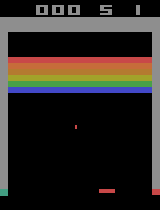

In [46]:
import gymnasium as gym

env = gym.make("ALE/Breakout-v5", render_mode='rgb_array', full_action_space=False)

# Various information about the environment
print ("action_space={}, observation_space={}".format(env.action_space.n, env.observation_space.shape))

observation = env.reset() # initial state/observation returned
#print (observation[0][180])
env.step(1) ## FIRE!

#env.render()  # returns an array of (210, 160, 3), each in the range [0-255]
Image.fromarray(env.render())

## 4. Install tensorflow


In [47]:
# %pip install tensorflow

import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.18.0'

### (\*) Image/frame preprocessing -- cropping, resizing and grayscale


[from https://towardsdatascience.com/getting-an-ai-to-play-atari-pong-with-deep-reinforcement-learning-47b0c56e78ae]<br>
Currently, the frames received from openai are much larger than we need, with a much higher resolution than we need. We don’t need any of the white space at the bottom, or any pixel above the white stripe at the top.

So we first crop the image so that only the important area is displayed. Next, we convert the image to grayscale if desired. Finally we convert the image datatype to np.uint8 (to save space than regular int).


In [48]:
import numpy as np

def crop_Atari_frame(frame):
    return frame[30:-12,5:-4]  # crop out irrelevant parts in the frame/image

def resize_and_gray(frame, newsize, gray = False):
    """ converts the frame/image array, possibly reduce to the gray scale,
        then resizes to the new size.
    """
    frame = crop_Atari_frame(frame)       # first crop the frame/array
    im = Image.fromarray(np.uint8(frame)) # convert the array to a PIL image
    if gray:
      im = ImageOps.grayscale(im)  # convert to grayscale using PIL ImageOps

    im = im.resize(newsize)  # resize the PIL image to the desired size
    return np.array(im, dtype = np.uint8) # convert back to an np array


In [49]:
import cv2
def crop_Atari_frame_cv2(frame):
        # Define cropping region
    x_start = 5  # Starting x-coordinate
    y_start = 30  # Starting y-coordinate
    width = frame.shape[1] - 10  # Width of the cropped region
    height = frame.shape[0] - 42  # Height of the cropped region
    # Crop using slicing
    cropped_frame = frame[y_start:y_start + height, x_start:x_start + width]
    return cropped_frame

def resize_and_gray_cv2(frame, newsize, gray=False):
    frame = crop_Atari_frame_cv2(frame)
    if gray:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    return cv2.resize(frame, newsize, interpolation=cv2.INTER_AREA)



Image shape: (84, 84, 3)


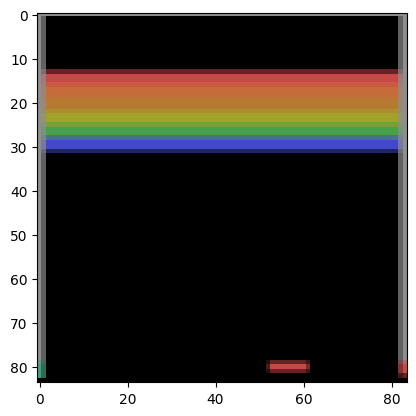

In [50]:
import gymnasium as gym
import matplotlib.pyplot as plt

env = gym.make("ALE/Breakout-v5", render_mode='rgb_array', full_action_space=False)
state = env.reset()
env.step(1)

newsize = (84, 84)  # reduced, new size!!

## convert the frame to a smaller color image
first_frame = resize_and_gray_cv2(state[0], newsize)  # new size, but still in color
print ("Image shape: {}".format(first_frame.shape))
plt.imshow(first_frame)

Image shape: (84, 84)


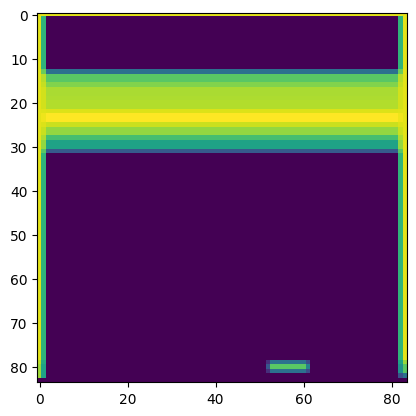

In [51]:
## convert the frame to a smaller grayscale image
first_frame = resize_and_gray_cv2(state[0], newsize, True) # new size, in grayscale
print ("Image shape: {}".format(first_frame.shape))
plt.imshow(first_frame)

## 5. Define QNetwork and Memory


In [52]:
from keras import layers
from collections import deque

class QNetwork:
    def __init__(self, input_shape=(84, 84, 3), action_size=4, hidden_size=126,
                 learning_rate = 0.001):
        # First fix up input_shape in case it is a 2D grayscale image
        if len(input_shape) < 3:
            input_shape = (input_shape[0], input_shape[1], 1)
        print ('input_shape = {}'.format(input_shape))

        # Model in the original Deepmind DQN paper (but reduced to assume one frame)
        self.model = keras.Sequential()
        self.model.add(layers.Conv2D(32, 8, strides=4, activation="relu",
                                    input_shape=input_shape))
        self.model.add(layers.Conv2D(64, 4, strides=2, activation="relu"))
        self.model.add(layers.Conv2D(64, 3, strides=1, activation="relu"))
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(hidden_size, activation="relu"))
        self.model.add(layers.Dense(action_size, activation="linear"))

        # other compile parameters
        self.optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
        self.model.compile(loss=keras.losses.Huber(), optimizer=self.optimizer)


class Memory():
    """ Replay memory """
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)),
                               size=batch_size,
                               replace=False)
        return [self.buffer[ii] for ii in idx]

    def __len__(self):
        return len(self.buffer)

### 6. Fill the Memory with episode steps


In [53]:
###################################
## Populate the experience memory
###################################

# Newly create the Atari Breakout game environment
env = gym.make("ALE/Breakout-v5", render_mode='rgb_array', full_action_space=False)
newsize = (84, 84)
grayscale = False

# Memory parameters
memory_size = 100000            # memory capacity
batch_size = 16                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

INIT_MEMORY = 100

memory = Memory(max_size=memory_size)

#----------------
print ("* Populate the experience memory with {} steps *".format(INIT_MEMORY))

# Initialize the simulation
observation = env.reset()
state = resize_and_gray_cv2(observation[0], newsize)

# Make a bunch of random actions and store the experiences
for _ in range(INIT_MEMORY):
    # render commented since it doesn't work well on CoLab without video
    #env.render()

    # Make a/one random action
    action = env.action_space.sample()
    # take the action
    next_state, reward, done, info, _ = env.step(action)

    # resize the image of next_state
    next_state = resize_and_gray_cv2(next_state, newsize, grayscale)

    # Add experience (a four-tuple) to memory.
    # (**) Keras predict processes a batch, so when you're using a single
    #  image, you need to add it to a list (by expanding the row dimension):
    memory.add((np.expand_dims(state, axis=0), action, reward,
                np.expand_dims(next_state, axis=0), done))

    if done:
        # Start a new episode
        env.reset()
        # Take one random step to get started
        state, reward, done, info = env.step(env.action_space.sample())
        state = resize_and_gray_cv2(state, newsize, grayscale)
    else:
        # go to the next state
        state = next_state

print ("Done!")

* Populate the experience memory with 100 steps *
Done!


## 7. Create DQN networks ('model_pred', which utilizes 'model_target') as Agent


In [54]:
# The first model makes the predictions for Q-values which are used to
# make a action.
image_shape = (memory.buffer[0][0][0]).shape
num_actions = env.action_space.n

model_pred = QNetwork(input_shape = image_shape, action_size = num_actions,
                      hidden_size=126)

# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 1000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = QNetwork(input_shape = image_shape, action_size = num_actions,
                        hidden_size=126)

input_shape = (84, 84, 3)
input_shape = (84, 84, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Some code to inspect memory, states etc.


(1, 84, 84, 3)


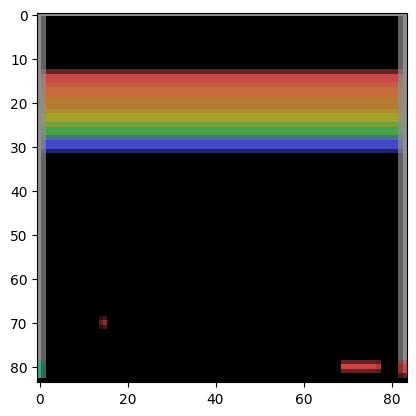

In [55]:
frame = memory.sample(1)[0]
frame_state = frame[0]      # 1st element in the four tuple
print(frame_state.shape)    # still in a batch of one

plt.imshow(frame_state[0])  # show only the image

(\*\*) Convert the image into range \[0, 1\], then call 'predict' in model_pred.model


In [56]:
# convert values of the image into range [0, 1]
frame_state = frame_state / 255.0

# Now make predictions (for all actions)
predictions = model_pred.model.predict(frame_state)
print (predictions[0])  # [0] because there is only one result in predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
[ 0.03349782  0.01174341  0.01028633 -0.00670424]


# 8. Your Training Code goes here!!!


In [65]:
from logging import log
import csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os


log_file = 'training_log.csv'
with open(log_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Episode', 'Reward', 'Epsilon', 'Loss', 'Steps', 'Batch Size'])  # Added 'Batch Size' column


# Hyperparameters
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.01
epsilon_decay = 0.9995
learning_rate = 0.0001
update_target_every = 1000
batch_size = 32
max_episodes = 5000

# --- Dynamic Batch Size Parameters ---
minimum_batch_size = 16  # Set a minimum batch size
maximum_batch_size = 128  # Set a maximum batch size
initial_loss = 0.5  # Initial loss (or a reasonable value)
loss_threshold = 2
# -------------------------------------

# --- Network Update Frequency ---
update_frequency = 4  # Update every 4 steps
# --------------------------------
# Initialize update_counter
update_counter = 0  # Initialize the counter

log_interval = 20
log_if_max = False


# Optimization
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = keras.losses.Huber()

# Checkpoint saving
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model_pred=model_pred.model,
                                 model_target=model_target.model)

# Define train_step outside the loop
@tf.function(reduce_retracing=True)  # Add reduce_retracing=True
def train_step(states, actions, targets):
    with tf.GradientTape() as tape:
        q_values = model_pred.model(states)
        q_values_selected = tf.reduce_sum(tf.multiply(q_values, tf.one_hot(actions, num_actions)), axis=1)
        loss = loss_fn(targets, q_values_selected)
    grads = tape.gradient(loss, model_pred.model.trainable_variables)
    grads = [tf.clip_by_value(g, -1.0, 1.0) for g in grads]  # Example clipping to [-1, 1]
    optimizer.apply_gradients(zip(grads, model_pred.model.trainable_variables))
    return loss

# Training loop
max_reward = -float('inf')
for episode in range(max_episodes):
    state = env.reset()[0]
    state = resize_and_gray_cv2(state, newsize, grayscale)
    state = np.expand_dims(state, axis=0)
    total_reward = 0
    loss_list = []  # Track losses
    step_count = 0

    for step in range(10000): # Maximum steps per episode
        step_count += 1
        # Epsilon-greedy action selection
        if np.random.rand() <= epsilon:
            action = env.action_space.sample()
        else:
            q_values = model_pred.model.predict_on_batch(state / 255.0)
            action = np.argmax(q_values[0])

        accumulated_reward = 0
        for _ in range(4):  # Skip 4 frames (including the first one)
            next_state, reward, done, _, _ = env.step(action)
            accumulated_reward += reward
            if done:
                break

        next_state = resize_and_gray_cv2(next_state, newsize, grayscale)
        next_state = np.expand_dims(next_state, axis=0)
        total_reward += accumulated_reward  # Add accumulated reward

        memory.add((state, action, accumulated_reward, next_state, done))

        if len(memory) >= batch_size: # changed to check memory length
            minibatch = memory.sample(batch_size)

            states = np.array([i[0] for i in minibatch]) / 255.0
            states = states.squeeze(axis=1)
            actions = np.array([i[1] for i in minibatch])
            rewards = np.array([i[2] for i in minibatch])
            next_states = np.array([i[3] for i in minibatch]) / 255.0
            next_states = next_states.squeeze(axis=1)
            dones = np.array([i[4] for i in minibatch])

            # Calculate target Q-values with parallelism
            target_q_values = model_target.model.predict_on_batch(next_states)
            targets = rewards + gamma * np.max(target_q_values, axis=1) * (1 - dones)


            loss = train_step(states, actions, targets)
            loss_list.append(loss.numpy())  # save loss for current batch

            average_loss = np.mean(loss_list)

            if average_loss > loss_threshold:
                batch_size = max(batch_size // 2, minimum_batch_size)  # Reduce batch size, with a minimum
            else:
                batch_size = min(batch_size * 2, maximum_batch_size)  # Increase batch size, with a maximum
            # Update loss_threshold (e.g., using a moving average)
            loss_threshold = 0.9 * loss_threshold + 0.1 * average_loss

        # --- Network Update Frequency ---
        if update_counter % update_frequency == 0 and len(memory) >= batch_size:  # Update prediction network
            model_target.model.set_weights(model_pred.model.get_weights())
            update_counter = 0  # Reset update counter
        # --------------------------------

        update_counter += 1  # Increment update counter
        state = next_state
        if done:
            break

    # Update target network periodically
    if episode % update_target_every == 0:
        model_target.model.set_weights(model_pred.model.get_weights())

    # Decay exploration rate
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    # Checkpoint saving based on max reward
    if total_reward > max_reward:
        log_if_max = True
        max_reward = total_reward
        checkpoint.save(file_prefix=checkpoint_prefix)
        print("Max Reward Updated, Checkpoint saved.")
    print(f"Episode {episode} | Total Reward: {total_reward} | Steps: {step_count} | Epsilon: {epsilon:.4f}")

    if episode % log_interval == 0 or log_if_max:
        with open(log_file, 'a', newline='') as csvfile:
          writer = csv.writer(csvfile)
          writer.writerow([episode, total_reward, epsilon, np.mean(loss_list), step_count, batch_size])  # Added batch_size
        log_if_max = False



Streaming output truncated to the last 5000 lines.
Episode 11 | Total Reward: 2.0 | Steps: 64 | Epsilon: 0.9940
Episode 12 | Total Reward: 3.0 | Steps: 66 | Epsilon: 0.9935
Episode 13 | Total Reward: 2.0 | Steps: 55 | Epsilon: 0.9930
Episode 14 | Total Reward: 0.0 | Steps: 42 | Epsilon: 0.9925
Episode 15 | Total Reward: 3.0 | Steps: 71 | Epsilon: 0.9920
Episode 16 | Total Reward: 1.0 | Steps: 44 | Epsilon: 0.9915
Episode 17 | Total Reward: 1.0 | Steps: 53 | Epsilon: 0.9910
Episode 18 | Total Reward: 2.0 | Steps: 56 | Epsilon: 0.9905
Episode 19 | Total Reward: 3.0 | Steps: 72 | Epsilon: 0.9900
Episode 20 | Total Reward: 2.0 | Steps: 61 | Epsilon: 0.9896
Episode 21 | Total Reward: 2.0 | Steps: 73 | Epsilon: 0.9891
Episode 22 | Total Reward: 2.0 | Steps: 57 | Epsilon: 0.9886
Episode 23 | Total Reward: 0.0 | Steps: 32 | Epsilon: 0.9881
Episode 24 | Total Reward: 1.0 | Steps: 54 | Epsilon: 0.9876
Episode 25 | Total Reward: 0.0 | Steps: 37 | Epsilon: 0.9871
Episode 26 | Total Reward: 3.0 | S

Store


In [66]:
import tensorflow as tf
import os

# Directory to store the models
model_dir = 'saved_models'  # Create this directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save model_pred using tf.saved_model, adding .keras extension
model_pred_path = os.path.join(model_dir, 'model_pred.keras')
model_pred.model.save(model_pred_path)

# Save model_target using tf.saved_model, adding .keras extension
model_target_path = os.path.join(model_dir, 'model_target.keras')
model_target.model.save(model_target_path)

print(f"Models saved to directory: {model_dir}")

Models saved to directory: saved_models


load


In [67]:
import tensorflow as tf
import os

# Directory where models are stored
model_dir = 'saved_models'

# Load model_pred
model_pred_path = os.path.join(model_dir, 'model_pred.keras')
loaded_model_pred = tf.keras.models.load_model(model_pred_path)

# Load model_target
model_target_path = os.path.join(model_dir, 'model_target.keras')
loaded_model_target = tf.keras.models.load_model(model_target_path)

print("Models loaded successfully!")

Models loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## 9. Try out the learned policy!!

Utility functions related to video


In [68]:
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only
import glob
import io
from IPython import display as ipythondisplay
from IPython.display import HTML

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

def wrap_env(env):
  env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
  return env

In [ ]:
#Loading using checkpoint
# import tensorflow as tf

# # Load the saved model
# checkpoint = tf.train.Checkpoint(optimizer=optimizer,
#                                  model_pred=model_pred.model,
#                                  model_target=model_target.model)
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [69]:
# First wrap the enviroment in a video-recording environment
env = wrap_env(env)

num_episodes = 10
total_score = 0

newsize = (84, 84)

for _ in range(num_episodes):
    # for each episode
    observation = env.reset()
    state = resize_and_gray_cv2(observation[0], newsize)
    done = False
    score = 0

    #while not done:
    for i in range(50):
        if i % 4 == 0:
          env.render()

        # Get action from the model_pred
        state = state / 255.0
        predictions = model_pred.model.predict(np.expand_dims(state, axis=0), verbose=0)[0]
        max_indices = np.where(predictions == np.max(predictions))[0]  # indices of max values
        action = np.random.choice(max_indices)  # break the ties randomly

        #action = np.argmax()

        # take the action
        next_state, reward, done, info = env.step(action)
        next_state = resize_and_gray_cv2(next_state, newsize, grayscale)

        score += reward
        state = next_state

env.close()
show_video()

In [71]:
# First wrap the enviroment in a video-recording environment
env = wrap_env(env)

num_episodes = 20
total_score = 0

newsize = (84, 84)

for _ in range(num_episodes):
    # for each episode
    observation = env.reset()
    state = resize_and_gray_cv2(observation[0], newsize)
    done = False
    score = 0

    #while not done:
    for i in range(50):
        if i % 4 == 0:
          env.render()

        # Get action from the model_pred
        state = state / 255.0
        predictions = loaded_model_pred.predict(np.expand_dims(state, axis=0), verbose=0)[0]
        max_indices = np.where(predictions == np.max(predictions))[0]  # indices of max values
        action = np.random.choice(max_indices)  # break the ties randomly

        #action = np.argmax()

        # take the action
        next_state, reward, done, info = env.step(action)
        next_state = resize_and_gray_cv2(next_state, newsize, grayscale)

        score += reward
        state = next_state

env.close()
show_video()